# Advanced Uses

In [1]:
import numpy as np
import torch
from neurodiffeq.neurodiffeq import safe_diff as diff
from neurodiffeq.ode import solve, solve_system
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.conditions import IVP

import matplotlib.pyplot as plt
%matplotlib notebook

## Tuning the Solver

The `solve*` functions (in `neurodiffeq.ode`, `neurodiffeq.pde`, `neurodiffeq.pde_spherical`) and `Solver*` classes (in `neurodiffeq.solvers`) choose some hyperparameters by default. For example, in `neurodiffeq.solver.Solver1D`, by default:
* the solution is approximated by a fully connected network of 2 hidden layers with 32 units each (tanh activation),
* for each epoch we train on 16 different points that are generated by adding a Gaussian noise on the 32 equally spaced points on the $t$ domain,
* an Adam optimizer with learning rate 0.001 is used

Sometimes we may want to choose these hyperparameters ourselves. We will be using the harmonic oscillator problem from above to demonstrate how to do that.

### Simple Harmonic Oscillator Example
In the following example, we demonstrate how to change these default settings using the harmonic oscillator as an example.

The differential equation and the initial condition are:
$$
\frac{\partial^2 u}{\partial t^2} + u = 0\\
u\bigg{|}_{t=0} = 0 \quad
\frac{\partial u}{\partial t}\bigg{|}_{t=0} = 1
$$



In [2]:
# Note that the function maps (u, t) to a single-entry list
harmonic_oscillator = lambda u, t: [ diff(u, t, order=2) + u ]
init_val_ho = IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)

### Specifying the Networks

In [3]:
from neurodiffeq.networks import FCNN # fully-connect neural network
import torch.nn as nn                 # PyTorch neural network module

Whether you are using a `neurodiffeq.solvers.Solver1D` instance or the legacy functions `neurodiffeq.ode.solve` and `neurodiffeq.ode.solve_system` to solve differential equations, you can specify the network architecture you want to use.

The architecture must be defined as a subclass of `torch.nn.Module`. If you are familiar with PyTorch, this process couldn't be simpler. If you don't know PyTorch at all, we have defined a `neurodiffeq.networks.FCNN` for you. `FCNN` stands for Fully-Connected Neural Network. You can tweak it any how you want by specifying  

1. `hidden_units`: number of units for each hidden layer. If you have 3 hidden layers with 32, 64, and 16 neurons respectively, then `hidden_units` should be a tuple `(32, 64, 16)`.

2. `actv`: a `torch.nn.Module` *class*. e.g. `nn.Tanh`, `nn.Sigmoid`. Impirically, [Swish](https://arxiv.org/abs/1710.05941) works better in many situations. We have implemented a `Swish` activation in `neurodiffeq.networks` for you to try out.

3. `n_input_units` and `n_output_units`: number of input/output units of the network. This is largely dependent on your problem. In most cases, `n_output_units` should be 1. And `n_input_units` should be the number of independent variables. In the case of ODE, this is 1, since we only have a single independent variable $t$.

If you want more flexibility than only using fully connected networks, check out [PyTorch's tutorials](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html) on defining your custom `torch.nn.Module`. **Pro tip: it's simpler than you think :)**

Once you figure out how to define your own network (as an instance of `torch.nn.Module`), you can pass it to 

1. `neurodiffeq.solvers.Solver1D` and other `Solver`s in this Module by specifying `nets=[your_net1, your_net2, ...]`; or
2. `neurodiffeq.ode.solve`, `neurodiffeq.pde.solve2D`, `neurodiffeq.pde_spherical.solve_spherical`, etc., by specifying `net=your_net`; or
3. `neurodiffeq.ode.solve_system`, `neurodiffeq.pde.solve2D_sytem`, `neurodiffeq.pde_spherical.solve_spherical_system`, etc., by specifying `nets=[your_net1, your_net2, ...]`.

Notes:
* Only the 1st way (using a `Solver`) is recommended, the 2nd and 3rd way (using a `solve*` function) are deprecated will some day be removed;
* In the 2nd case, these functions assumes you only solving a single equation for a single function, so you pass in **a single network** &#151; `net=...`;
* In the 1st and 3rd cases, they assume you are solving arbitraily many equations for arbitrarily functions, so you pass in **a list of networks** &#151; `nets=[...]`.


Here we create a fully connected network with 3 hidden layers, each with 16 units and tanh activation. We then use it to fit our ODE solution.

<IPython.core.display.Javascript object>


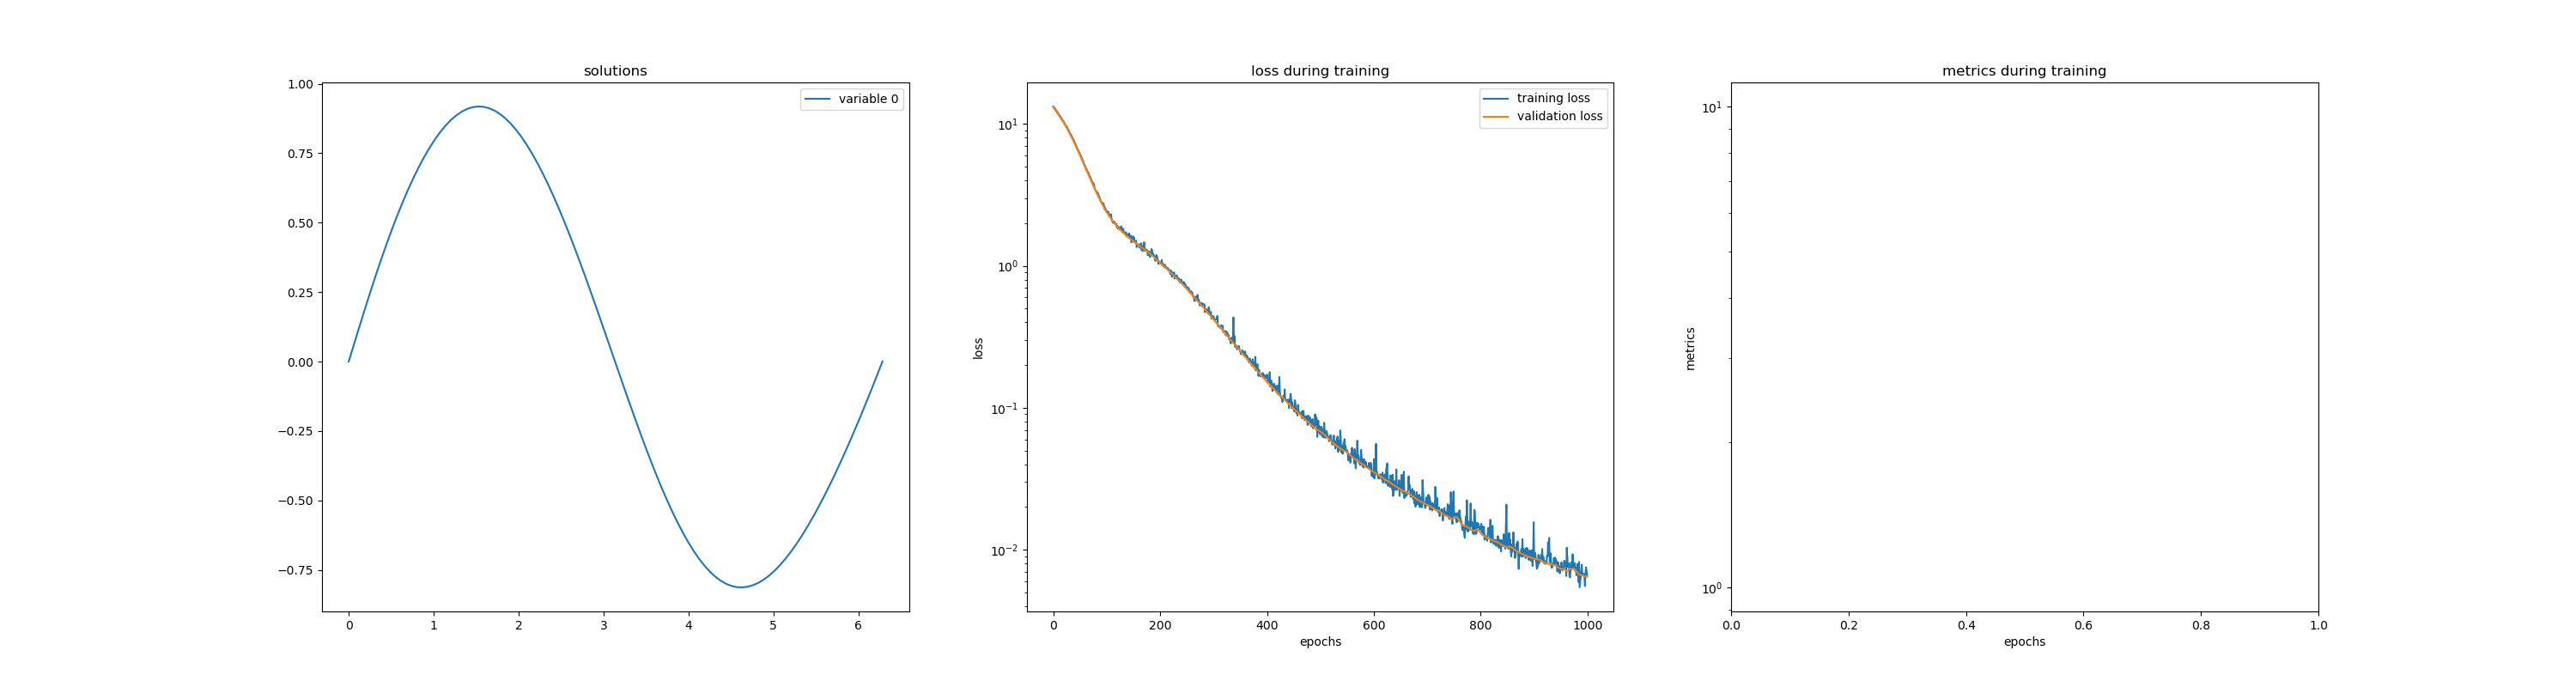

In [4]:
%matplotlib notebook
# Specify the network architecture
net_ho = FCNN(
    hidden_units=(16, 16, 16), actv=nn.Tanh
)

# Create a monitor callback
from neurodiffeq.callbacks import MonitorCallback
from neurodiffeq.monitors import Monitor1D
monitor_callback = MonitorCallback(Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100))

# Create a solver
solver = Solver1D(
    ode_system=harmonic_oscillator,  # Note that `harmonic_oscillator` returns a single-entry list
    conditions=[init_val_ho],        # Again, `conditions` is a single-entry list
    t_min=0.0,
    t_max=2*np.pi,
    nets=[net_ho],                   # Again, `nets` is a single-entry list
)

# Fit the solver
solver.fit(max_epochs=1000, callbacks=[monitor_callback])

# Obtain the solution
solution_ho = solver.get_solution()

### Specifying the Training Set and Validation Set

Both `Solver*` classes and `solve*` functions train the neural network on a new set of points, randomly sampled every time. These examples are $t$s drawn from the domain of $t$. The way these $t$s are generated can be specified by passing a `neurodiffeq.generators.BaseGenerator` object as the `train_generator` argument (and `valid_generator` argument) to `Solver*` classes or `solve*` functions. An `Generator` can be intialized by the following arguments:

* `size`: the number of $t$s generated for each epoch

* `t_min` and `t_max`: the domain of $t$ from which we want to draw $t$s

* `method`: a string indicating how to generate the $ts$. It should be one of the following: 'uniform', 'equally-spaced', 'equally-spaced-noisy'. If 'uniform', each $t$ will be drawn independently from the uniform distribution $\text{Unif}($`t_min`, `t_max`$)$. If 'equally-spaced', all $t$s generated in the same epoch will form a grid where each $t$ is equally spaced. 'equally-spaced-noisy' is a noisy version of 'equally-spaced' where we add a Gaussian noise $\epsilon \sim \mathcal{N}(0, ($`t_max`-`t_min`)/(4*`size`) $)$

Here we create an `Generator` that generates 64 $t$s drawn from a uniform distribution for every epoch. Then we use it to solve the ODE. In the meantime, foor every epoch, we will use another `Generator` that generates 128 $t$s that are equally spaced in the domain we want to solve.

In [5]:
from neurodiffeq.generators import Generator1D

<IPython.core.display.Javascript object>


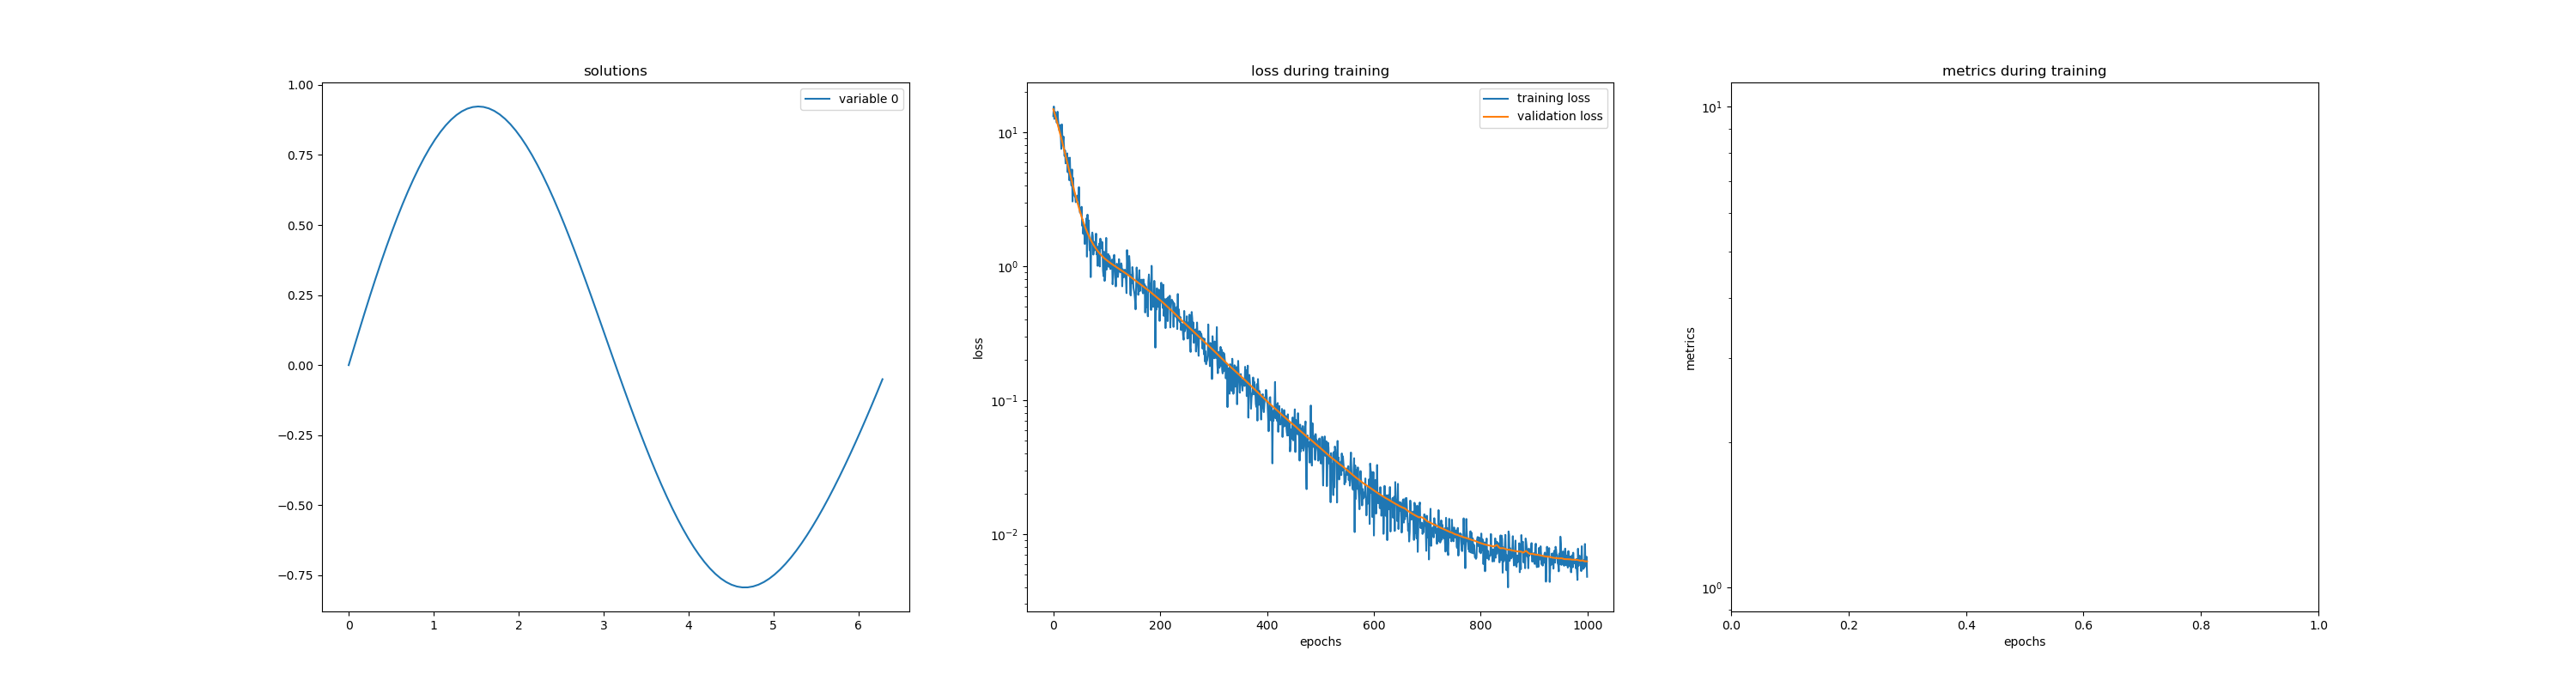

In [6]:
%matplotlib notebook
# specify the training set and validation set
train_gen = Generator1D(size=64,  t_min=0.0, t_max=2*np.pi, method='uniform')
valid_gen = Generator1D(size=128, t_min=0.0, t_max=2*np.pi, method='equally-spaced')

# solve the ODE
solver = Solver1D(
    ode_system=harmonic_oscillator, 
    conditions=[init_val_ho], 
    t_min=0.0, 
    t_max=2*np.pi,
    train_generator=train_gen, 
    valid_generator=valid_gen,
)
solver.fit(
    max_epochs=1000, 
    callbacks=[MonitorCallback(Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100))]
)

solution_ho = solver.get_solution()

###  Specifying the Optimizer

We can change the optimization algorithms by passing a `torch.optim.Optimizer` object to `Solver*` classes and `solve*` functions as the `optimizer` argument. 

If you are familiar with PyTorch, you know that to initialize an `Optimizer`, we need to tell it the parameters to optimize. In other words, if we want to use a different optimizer from the default one, we also need to create our own networks. 

Here we create a fully connected network and an `SGD` optimizer to optimize its weights. Then we use them to solve the ODE.

In [7]:
from torch.optim import SGD

<IPython.core.display.Javascript object>


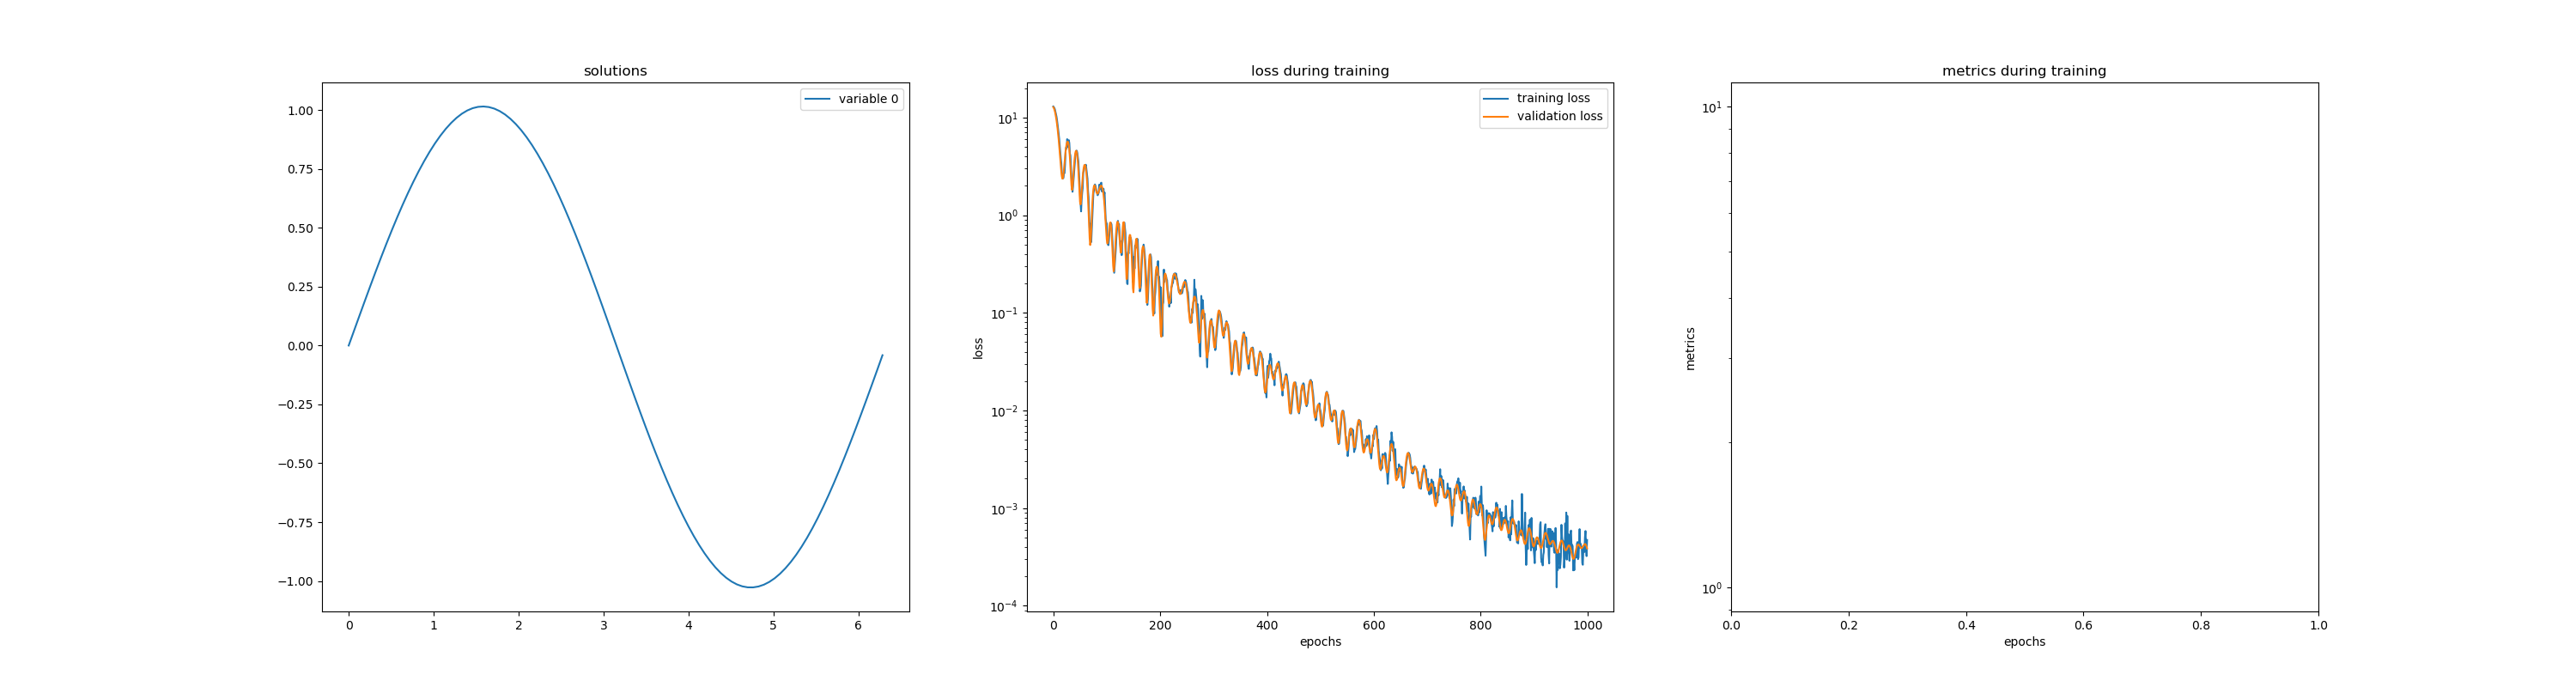

In [8]:
%matplotlib notebook
# specify the network architecture
net_ho = FCNN(
    n_input_units=1,
    n_output_units=1,
    hidden_units=(16, 16, 16), 
    actv=nn.Tanh,
)

nets = [net_ho]

# specify the optimizer
from itertools import chain

sgd_ho = SGD(
    chain.from_iterable(n.parameters() for n in nets), # this gives all parameters in `nets`
    lr=0.001,                                          # learning rate
    momentum=0.99,                                     # momentum of SGD
)

# solve the ODE
solver = Solver1D(
    ode_system=harmonic_oscillator,
    conditions=[init_val_ho],
    t_min=0.0, 
    t_max=2*np.pi,
    nets=nets, 
    optimizer=sgd_ho,
)

solver.fit(
    max_epochs=1000, 
    callbacks=[MonitorCallback(Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100))]
)

solution_ho = solver.get_solution()

### Specifying the Loss Function

We can change the loss function by passing a `torch.nn._Loss` object to `solve` and `solve_system` as the `criterion` argument. 

Here we use the mean absolute loss to solve the ODE.

In [9]:
from torch.nn import L1Loss

<IPython.core.display.Javascript object>


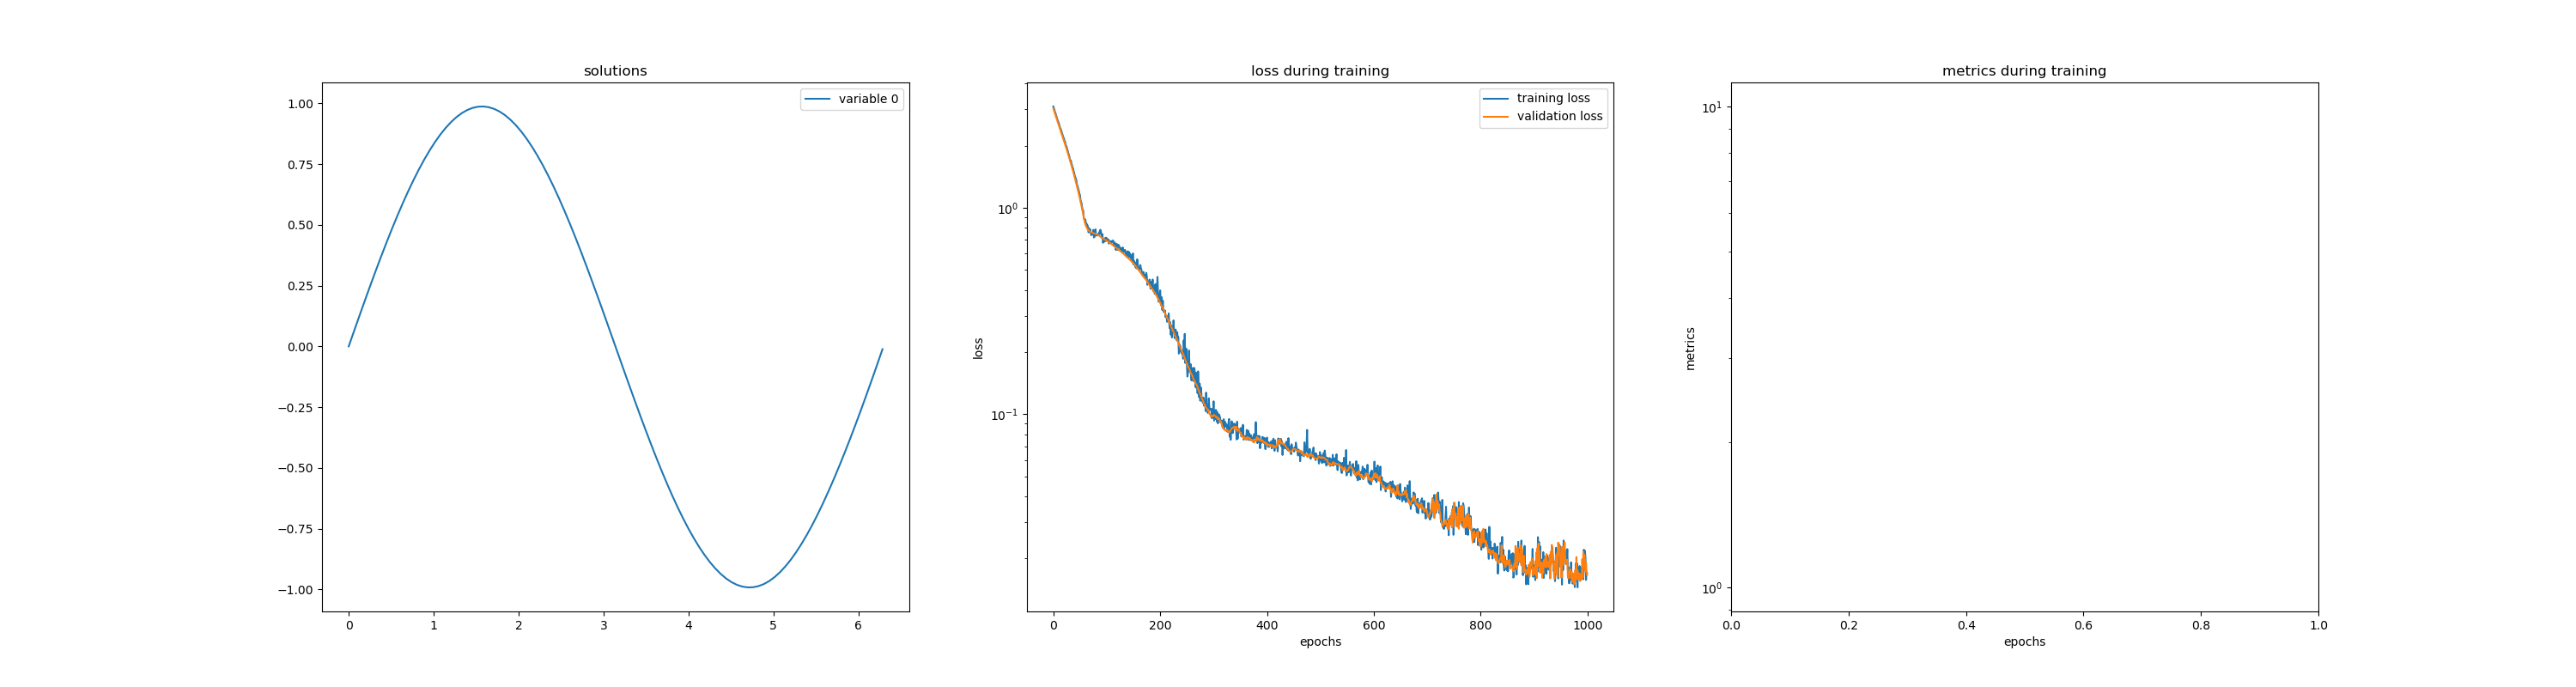

In [10]:
%matplotlib notebook
# solve the ODE
solver = Solver1D(
    ode_system=harmonic_oscillator, 
    conditions=[init_val_ho], 
    t_min=0.0, 
    t_max=2*np.pi,
    criterion=L1Loss(),
)
solver.fit(
    max_epochs=1000, 
    callbacks=[MonitorCallback(Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100))]
)

solution_ho = solver.get_solution()

## Access the Internals

When the network, generator, optimizer and loss function are specified outside `solve` and `solve_system` function, users will naturally have access to these objects. We may still want to access these objects when we are using default network architecture, generator, optimizer and loss function. We can get these internal objects by setting the `return_internal` keyword to `True`. This will add a third element in the returned tuple, which is a dictionary containing the reference to the network, example generator, optimizer and loss function.

In [11]:
# specify the ODE system
parametric_circle = lambda x1, x2, t : [diff(x1, t) - x2, 
                                        diff(x2, t) + x1]
# specify the initial conditions
init_vals_pc = [
    IVP(t_0=0.0, u_0=0.0),
    IVP(t_0=0.0, u_0=1.0),
]

# solve the ODE system
solution_pc, _, internal = solve_system(
    ode_system=parametric_circle, 
    conditions=init_vals_pc, 
    t_min=0.0, t_max=2*np.pi,
    return_internal=True
)

/Users/liushuheng/Documents/GitHub/neurodiffeq/neurodiffeq/ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(


In [12]:
internal

{'nets': [FCNN(
    (NN): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=2, bias=True)
    )
  ),
  FCNN(
    (NN): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=2, bias=True)
    )
  )],
 'conditions': [<neurodiffeq.conditions.IVP at 0x7f9a08074940>,
 'train_generator': <neurodiffeq.generators.SamplerGenerator at 0x7f9a07f16250>,
 'valid_generator': <neurodiffeq.generators.SamplerGenerator at 0x7f9a080749d0>,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ),
 'criterion': <function neurodiffeq.solvers.BaseSolver.__init__.<locals>.<lambda>(r)>}

You get more internal objects when using the `Solver`s. The process is demonstrated as follows:

In [13]:
parametric_circle = lambda x1, x2, t: [diff(x1, t) - x2, diff(x2, t) + x1]

init_vals_pc = [
    IVP(t_0=0.0, u_0=0.0),
    IVP(t_0=0.0, u_0=1.0),
]

solver = Solver1D(
    ode_system=parametric_circle,
    conditions=init_vals_pc,
    t_min=0.0,
    t_max=2*np.pi,
)

solver.fit(max_epochs=100)
internals = solver.get_internals()

In [14]:
internals

{'metrics': {},
 'n_batches': {'train': 1, 'valid': 4},
 'best_nets': [FCNN(
    (NN): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  ),
  FCNN(
    (NN): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )],
 'criterion': <function neurodiffeq.solvers.BaseSolver.__init__.<locals>.<lambda>(r)>,
 'conditions': [<neurodiffeq.conditions.IVP at 0x7f9a08044a00>,
 'global_epoch': 100,
 'lowest_loss': 0.026307572100156426,
 'n_funcs': 2,
 'nets': [FCNN(
    (NN): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
   